In [61]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import string
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from skimage.metrics import structural_similarity as ssim
from scipy.fftpack import dct
import tensorflow as tf
from tensorflow.keras.models import load_model
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

In [62]:
# === CONFIGURATION === #
IMG_SIZE = (64, 64)
NUM_PIXELS = 16
BITS_PER_COORD = 16
RESERVED_BITS = NUM_PIXELS * BITS_PER_COORD * 2
MESSAGE_BITS = 2 * 8
CHANNELS = 1
CLASS_NAMES = ['Normal', 'Attack', 'Faulty']

In [63]:
# === MESSAGE UTILS === #
def generate_random_message():
    return ''.join(random.choices(string.ascii_letters + string.digits, k=2))

def string_to_bits(s):
    return [int(b) for c in s.encode('utf-8') for b in format(c, '08b')][:MESSAGE_BITS]

def bits_to_string(bits):
    chars = []
    for i in range(0, len(bits), 8):
        byte = bits[i:i+8]
        if len(byte) == 8:
            chars.append(chr(int(''.join(map(str, byte)), 2)))
    return ''.join(chars)

In [64]:
# === COORDINATE CONVERSION === #
def coords_to_bits(coords):
    bits = []
    for y, x in coords:
        yb = format(y, f'0{BITS_PER_COORD}b')
        xb = format(x, f'0{BITS_PER_COORD}b')
        bits.extend(int(b) for b in yb + xb)
    return bits

def bits_to_coords(bits):
    coords = []
    for i in range(0, len(bits), 32):
        y = int(''.join(map(str, bits[i:i+16])), 2)
        x = int(''.join(map(str, bits[i+16:i+32])), 2)
        coords.append((y, x))
    return coords

In [65]:
# === CLEANING FUNCTION === #
def clean_message(s):
    return ''.join(c for c in s if c.isprintable())

In [66]:
# === EMBEDDING === #
def embed_lsb(image, bits, coords):
    flat = image.flatten()
    for i, (y, x) in enumerate(coords):
        idx = y * image.shape[1] + x
        flat[idx] = (flat[idx] & ~1) | bits[i]
    return flat.reshape(image.shape)

def embed_metadata(image, meta_bits):
    flat = image.flatten()
    for i in range(len(meta_bits)):
        flat[i] = (flat[i] & ~(1 << 7)) | (meta_bits[i] << 7)
    return flat.reshape(image.shape)

In [67]:
# === IG-BASED IMPORTANT PIXELS === #
def get_ig_pixels(model, image_tensor, label_index, top_k=NUM_PIXELS):
    def loss_fn(output): return output[:, label_index]
    saliency = Saliency(model, model_modifier=ReplaceToLinear(), clone=True)
    saliency_map = saliency(loss_fn, image_tensor)
    saliency_map = np.abs(saliency_map[0])
    if saliency_map.ndim == 3:
        saliency_map = np.mean(saliency_map, axis=-1)
    flat = saliency_map.flatten()
    indices = np.argsort(flat)[-top_k:]
    ys, xs = np.unravel_index(indices, saliency_map.shape)
    return list(zip(ys, xs))

In [68]:
def visualize_ig(image, saliency_map, true_class, pred_class, filename, output_dir):
    if saliency_map.ndim == 3:
        saliency_map = np.mean(saliency_map, axis=-1)

    # === Step 1: Select top-100 pixels ===
    flat = saliency_map.flatten()
    top_indices = np.argsort(flat)[-100:]
    mask = np.zeros_like(flat)
    mask[top_indices] = flat[top_indices]
    masked_saliency = mask.reshape(saliency_map.shape)

    # === Step 2: Normalize non-zero values ===
    nonzero = masked_saliency[masked_saliency > 0]
    if nonzero.size > 0:
        min_val = nonzero.min()
        max_val = nonzero.max()
        norm_saliency = (masked_saliency - min_val) / (max_val - min_val + 1e-8)
    else:
        norm_saliency = masked_saliency

    # === Step 3: Prepare image overlays ===
    grayscale_rgb = np.stack([image] * 3, axis=-1).astype(np.uint8)

    cmap = plt.get_cmap('turbo')
    heatmap_rgb = (cmap(norm_saliency)[:, :, :3] * 255).astype(np.uint8)

    overlay = grayscale_rgb.copy()
    top_mask = norm_saliency > 0
    overlay[top_mask] = heatmap_rgb[top_mask]

    # === Step 4: Plot all ===
    plt.figure(figsize=(18, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Original Image\nTrue: {true_class} | Pred: {pred_class}")
    plt.axis('off')

    # Raw IG (top-100)
    plt.subplot(1, 3, 2)
    plt.imshow(norm_saliency, cmap='hot')
    plt.title("Top-100 IG (Raw Scaled)")
    plt.axis('off')
    plt.colorbar(label="Pixel Importance", shrink=0.8)

    # Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Top-100 IG Overlay")
    plt.axis('off')
    plt.colorbar(label="Pixel Importance", shrink=0.8)

    # === Step 5: Save + Display ===
    os.makedirs(output_dir, exist_ok=True)
    out_path = os.path.join(output_dir, f"ig_vis_{filename}.png")
    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()  # ✅ Show in notebook
    plt.close()


In [69]:
# === DECODING === #
def decode_message_and_coords(image):
    flat = image.flatten()
    coord_bits = [(flat[i] >> 7) & 1 for i in range(RESERVED_BITS)]
    coords = bits_to_coords(coord_bits)
    msg_bits = [flat[y * image.shape[1] + x] & 1 for y, x in coords[:NUM_PIXELS]]
    return bits_to_string(msg_bits), coords

In [70]:
# === QUALITY METRICS === #
def calculate_mse(original, stego):
    return np.mean((original.astype(np.float32) - stego.astype(np.float32)) ** 2)

def calculate_psnr(mse, max_pixel=255.0):
    if mse == 0:
        return float('inf')
    return 20 * math.log10(max_pixel / math.sqrt(mse))

def calculate_ssim(original, stego):
    return ssim(original, stego)

def compute_dct_difference(original, stego):
    original_dct = dct(dct(original.T, norm='ortho').T, norm='ortho')
    stego_dct = dct(dct(stego.T, norm='ortho').T, norm='ortho')
    diff = np.abs(original_dct - stego_dct)
    return np.mean(diff), np.max(diff)

In [71]:
def process_folder(input_folder, model_path, output_excel, stego_output_folder, ig_vis_output_folder):
    model = load_model(model_path)
    results = []
    original_labels = []
    original_preds = []
    stego_preds = []

    image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    output_dir = os.path.dirname(output_excel)
    os.makedirs(stego_output_folder, exist_ok=True)
    os.makedirs(ig_vis_output_folder, exist_ok=True)

    for idx, filename in enumerate(image_files):
        print(f"[{idx + 1}/{len(image_files)}] Processing {filename}")
        image_path = os.path.join(input_folder, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"⚠️ Could not read {filename}. Skipping.")
            continue

        image = cv2.resize(image, IMG_SIZE)
        norm_img = image.astype(np.float32) / 255.0
        input_tensor = np.expand_dims(norm_img, axis=(0, -1))  # shape: (1, H, W, 1)

        # 🧠 Predict original image
        probs = model.predict(input_tensor, verbose=0)[0]
        pred_class_index = np.argmax(probs)
        pred_class_orig = CLASS_NAMES[pred_class_index]
        original_preds.append(pred_class_orig)

        # 🏷️ Get true label from folder name
        folder_name = os.path.basename(os.path.normpath(input_folder)).lower()
        if folder_name == "normal":
            true_label = "Normal"
        elif folder_name == "attack":
            true_label = "Attack"
        elif folder_name == "faulty":
            true_label = "Faulty"
        else:
            raise ValueError(f"Cannot determine true label from folder name: {folder_name}")
        original_labels.append(true_label)

        # 🔍 IG pixel selection using predicted class
        ig_pixels = get_ig_pixels(model, input_tensor, label_index=pred_class_index, top_k=NUM_PIXELS)

        # 🔥 Saliency map for visualization
        saliency = Saliency(model, model_modifier=ReplaceToLinear(), clone=True)
        saliency_map = saliency(lambda output: output[:, pred_class_index], input_tensor)

        visualize_ig(
            image=image,
            saliency_map=saliency_map[0],
            true_class=true_label,
            pred_class=pred_class_orig,
            filename=filename.split('.')[0],
            output_dir=ig_vis_output_folder
        )

        # 🧬 Embed message
        original_msg = generate_random_message()
        msg_bits = string_to_bits(original_msg)
        coord_bits = coords_to_bits(ig_pixels)

        msg_encoded_img = embed_lsb(image.copy(), msg_bits, ig_pixels)
        final_stego = embed_metadata(msg_encoded_img, coord_bits)

        # 🧠 Predict on stego image
        cnn_input = np.expand_dims(final_stego.astype(np.float32) / 255.0, axis=(0, -1))
        probs_stego = model.predict(cnn_input, verbose=0)[0]
        pred_class_index_stego = np.argmax(probs_stego)
        pred_class_after = CLASS_NAMES[pred_class_index_stego]
        stego_preds.append(pred_class_after)

        # 🔓 Decode and compare
        decoded_msg, decoded_coords = decode_message_and_coords(final_stego)
        original_clean = clean_message(original_msg)
        decoded_clean = clean_message(decoded_msg)

        print(f"Encoded Message: {original_clean}")
        print(f"Decoded Message: {decoded_clean}")
        print(f"Messages Match: {'Matched' if original_clean == decoded_clean else 'Mismatched'}\n")

        # 🧪 Image quality metrics
        mse_value = calculate_mse(image, final_stego)
        psnr_value = calculate_psnr(mse_value)
        ssim_value = calculate_ssim(image, final_stego)
        mean_dct_diff, max_dct_diff = compute_dct_difference(image, final_stego)

        # 💾 Save stego image
        stego_image_filename = f"stego_{filename}"
        stego_image_path = os.path.join(stego_output_folder, stego_image_filename)
        cv2.imwrite(stego_image_path, final_stego)

        # 📝 Store results
        results.append({
            "Image": filename,
            "Original Message": original_clean,
            "Decoded Message": decoded_clean,
            "Match": "Matched" if original_clean == decoded_clean else "Mismatched",
            "CNN Predicted Class": pred_class_after,
            "Confidence": round(probs_stego[pred_class_index_stego], 4),
            "Encoded Coords": str(ig_pixels),
            "Decoded Coords Match": "Matched" if ig_pixels == decoded_coords else "Mismatched",
            "True Label": true_label,
            "MSE": round(mse_value, 4),
            "PSNR": round(psnr_value, 2),
            "SSIM": round(ssim_value, 4),
            "Mean DCT Diff": round(mean_dct_diff, 4),
            "Max DCT Diff": round(max_dct_diff, 4)
        })

    # 📊 Confusion matrices
    df = pd.DataFrame(results)
    cm_original = confusion_matrix(original_labels, original_preds, labels=CLASS_NAMES)
    cm_stego = confusion_matrix(original_labels, stego_preds, labels=CLASS_NAMES)

    # 📈 Save confusion matrices
    for cm, title, name, cmap in [
        (cm_original, "Confusion Matrix BEFORE Embedding", "confusion_matrix_original", "Greens"),
        (cm_stego, "Confusion Matrix AFTER Embedding", "confusion_matrix_stego", "Blues")
    ]:
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(title)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{name}.png"))
        plt.close()

    # 📊 Count plots
    for key in ["Match", "Decoded Coords Match"]:
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df, x=key)
        plt.title(f"{key} Count")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{key.lower().replace(' ', '_')}_count.png"))
        plt.close()

    # 📋 Summary metrics
    summary_df = pd.DataFrame({
        "Average MSE": [df["MSE"].mean()],
        "Average PSNR (dB)": [df["PSNR"].mean()],
        "Average SSIM": [df["SSIM"].mean()],
        "Average Mean DCT Diff": [df["Mean DCT Diff"].mean()],
        "Average Max DCT Diff": [df["Max DCT Diff"].mean()],
        "Message Match Rate (%)": [(df["Match"] == "Matched").mean() * 100],
        "Coordinate Match Rate (%)": [(df["Decoded Coords Match"] == "Matched").mean() * 100],
        "CNN Accuracy After Embedding (%)": [(df["True Label"] == df["CNN Predicted Class"]).mean() * 100]
    })

    # 💾 Save to Excel
    with pd.ExcelWriter(output_excel, engine='openpyxl', mode='w') as writer:
        df.to_excel(writer, index=False, sheet_name='Per Image Results')
        summary_df.to_excel(writer, index=False, sheet_name='Summary Averages')

    print("\n✅ Done! Results saved to", output_excel)
    print("\n📊 AVERAGE METRICS ACROSS ALL IMAGES:")
    for col in summary_df.columns:
        val = summary_df[col].iloc[0]
        print(f"{col}: {val:.4f}" if isinstance(val, float) else f"{col}: {val}")


[1/772] Processing image_00001.png


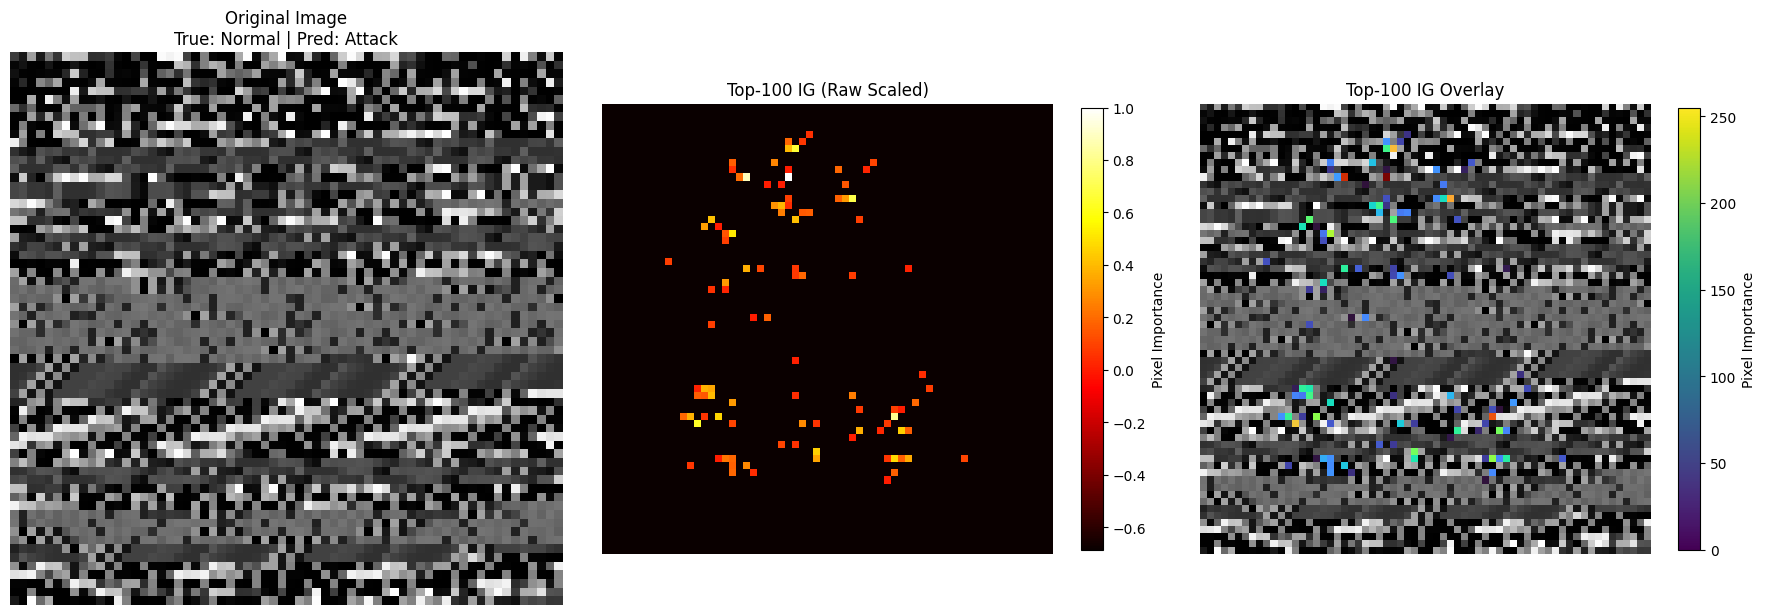

Encoded Message: zy
Decoded Message: zy
Messages Match: Matched

[2/772] Processing image_00002.png


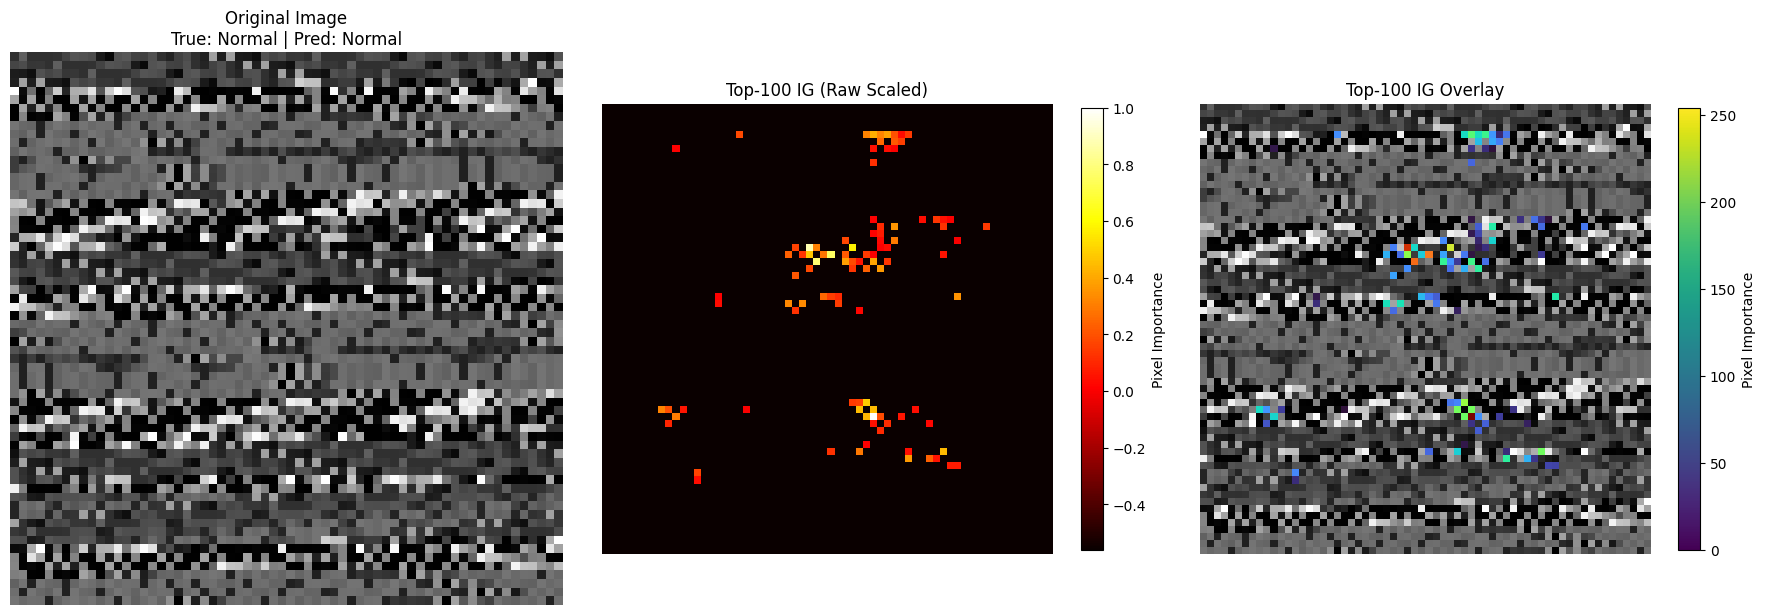

Encoded Message: mJ
Decoded Message: mJ
Messages Match: Matched

[3/772] Processing image_00003.png


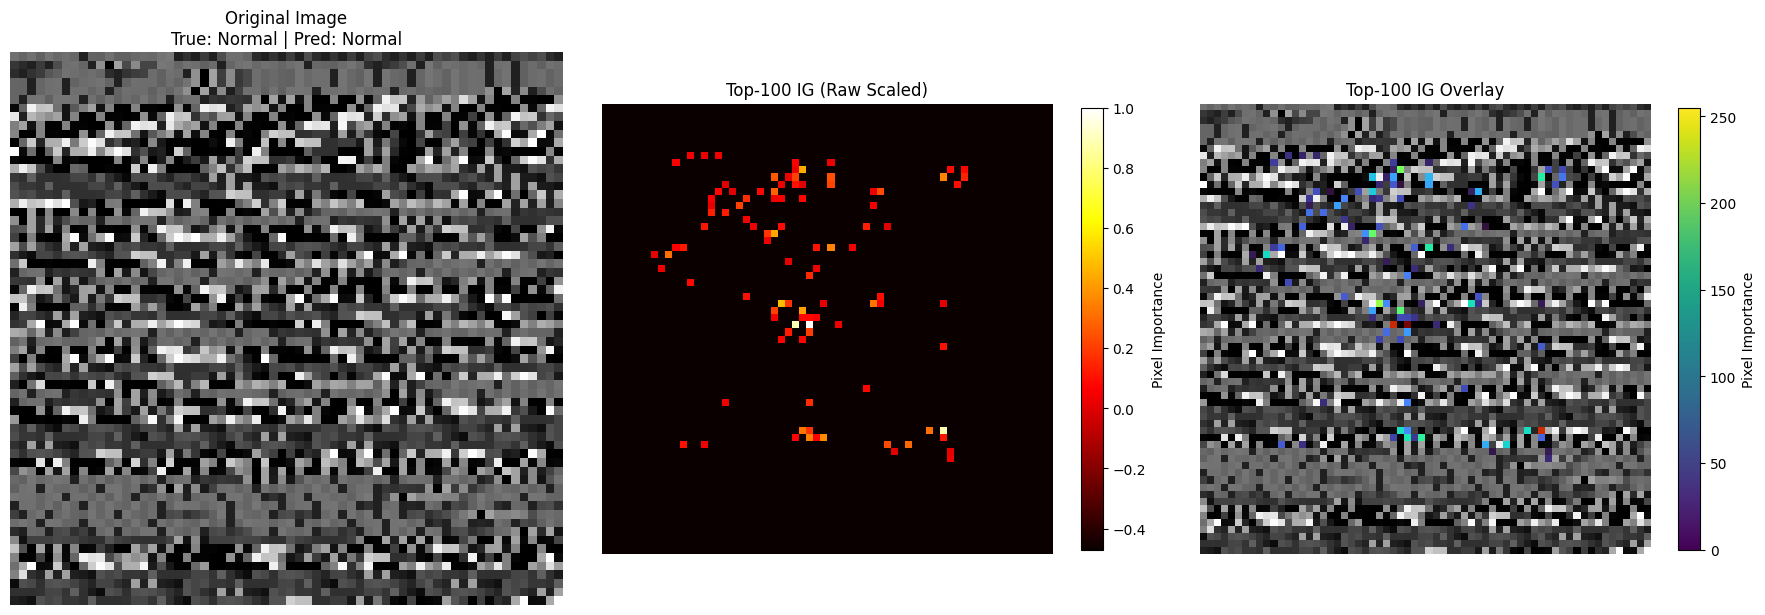

Encoded Message: gJ
Decoded Message: gJ
Messages Match: Matched

[4/772] Processing image_00004.png


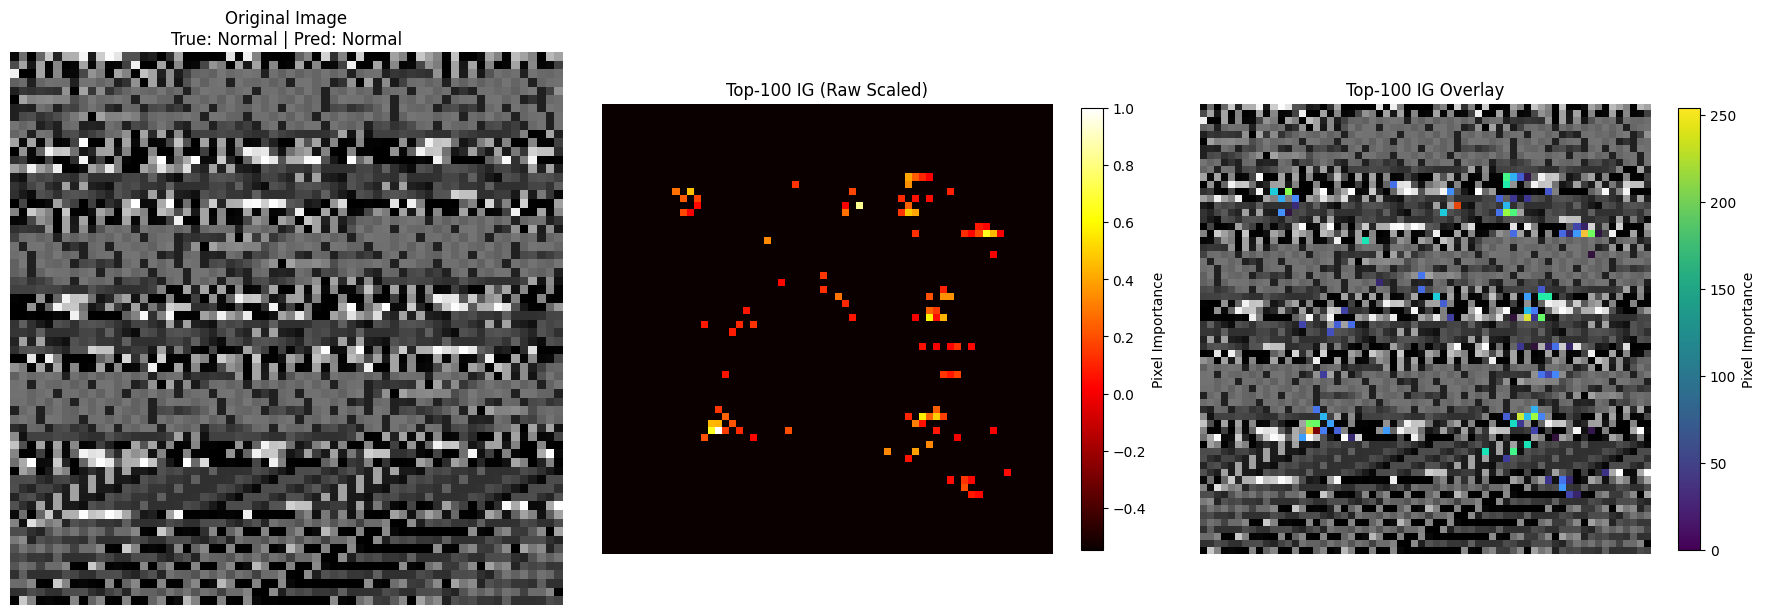

Encoded Message: KQ
Decoded Message: KQ
Messages Match: Matched

[5/772] Processing image_00005.png


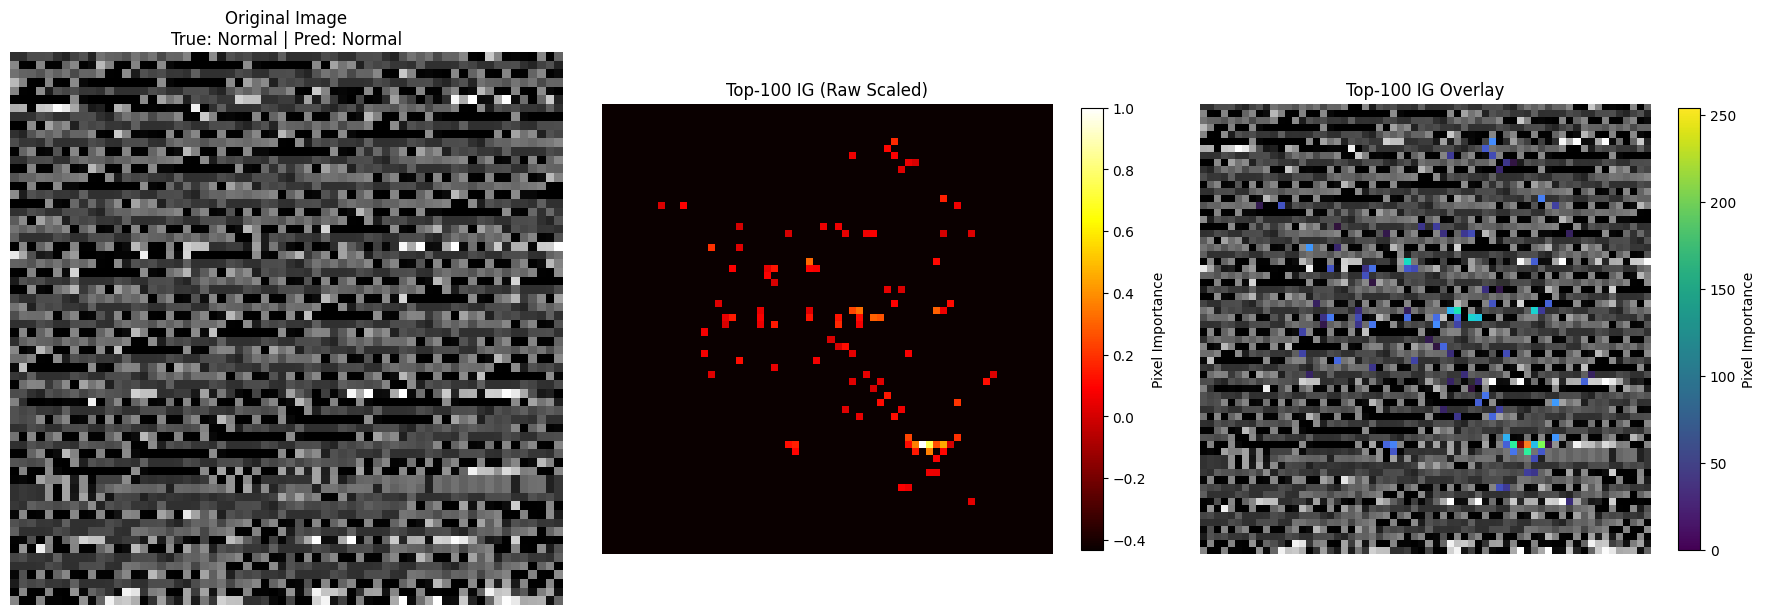

Encoded Message: JR
Decoded Message: JR
Messages Match: Matched

[6/772] Processing image_00006.png


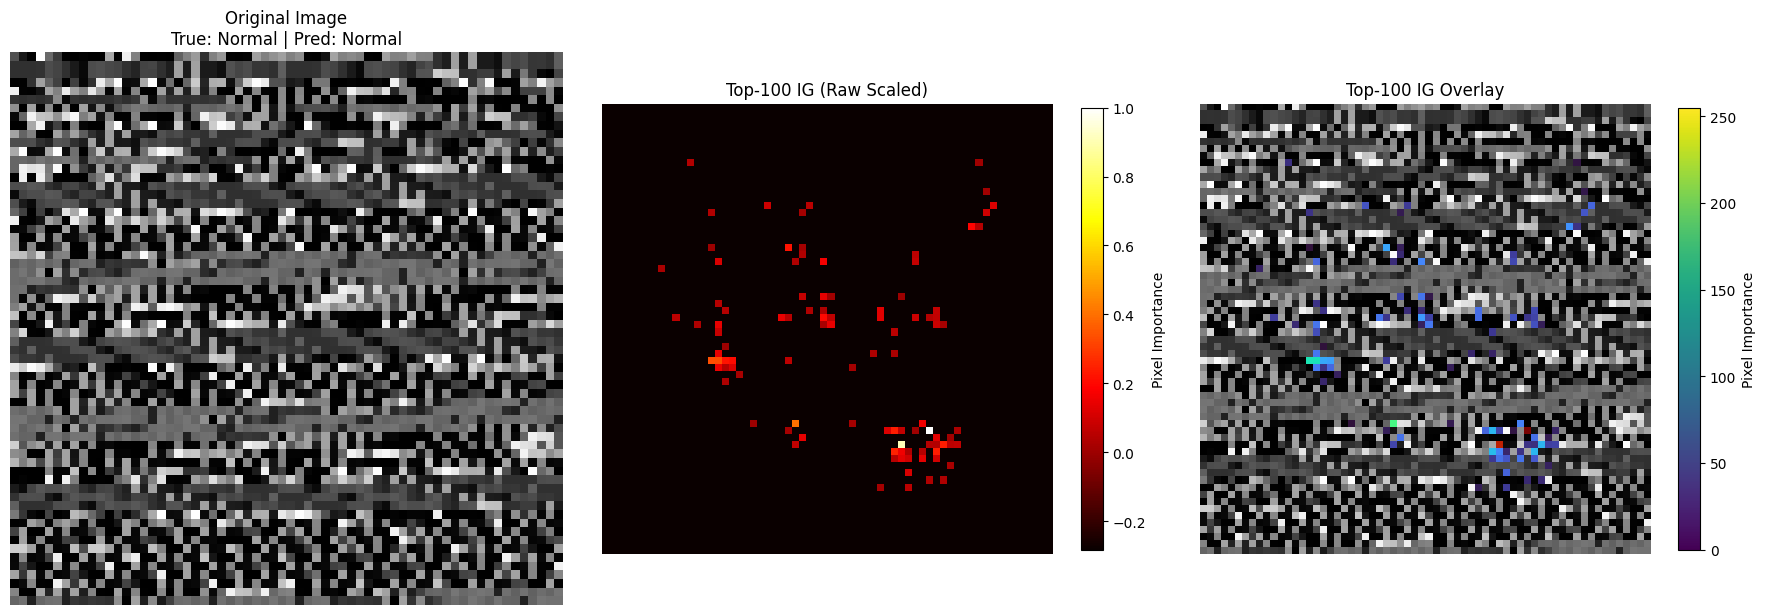

Encoded Message: o5
Decoded Message: o5
Messages Match: Matched

[7/772] Processing image_00007.png


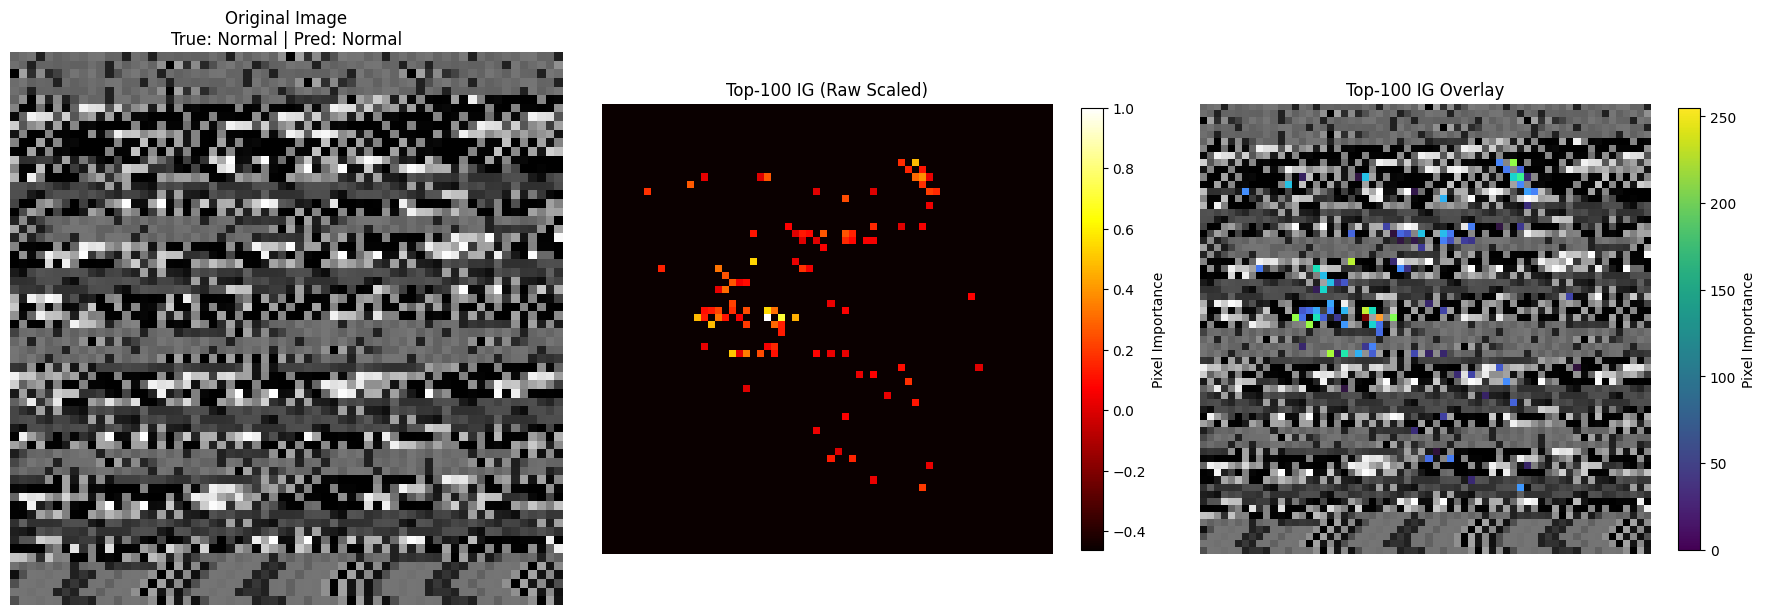

Encoded Message: Xe
Decoded Message: Xe
Messages Match: Matched

[8/772] Processing image_00008.png


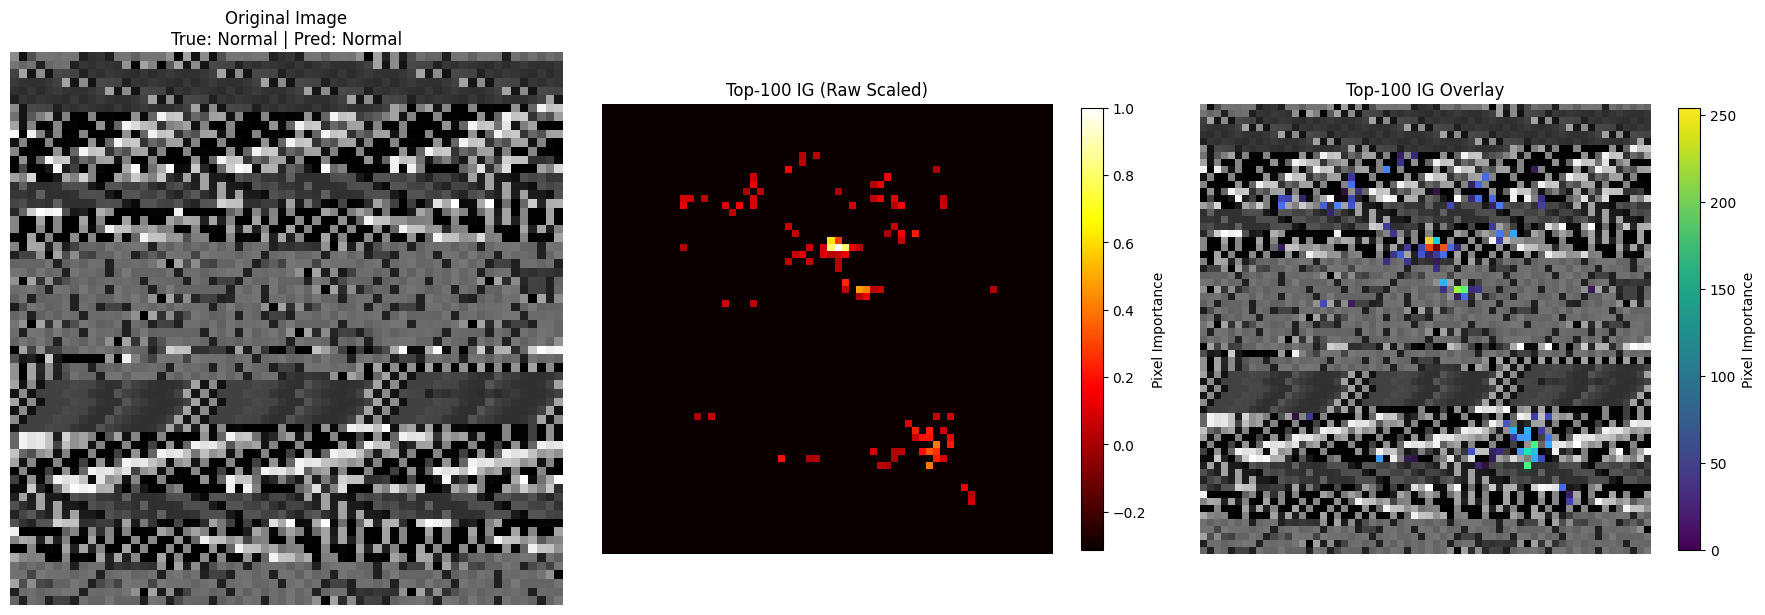

Encoded Message: Eb
Decoded Message: Eb
Messages Match: Matched

[9/772] Processing image_00009.png


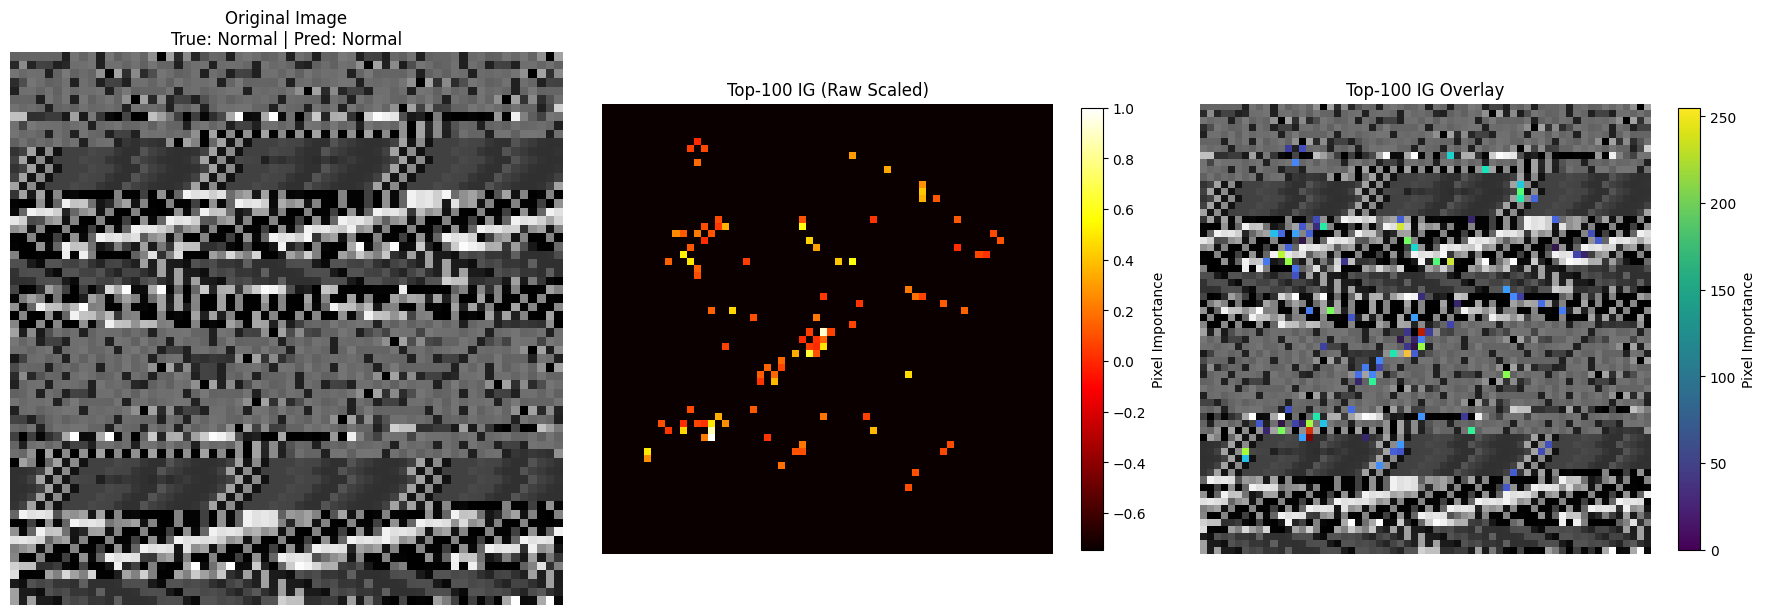

Encoded Message: pU
Decoded Message: pU
Messages Match: Matched

[10/772] Processing image_00010.png


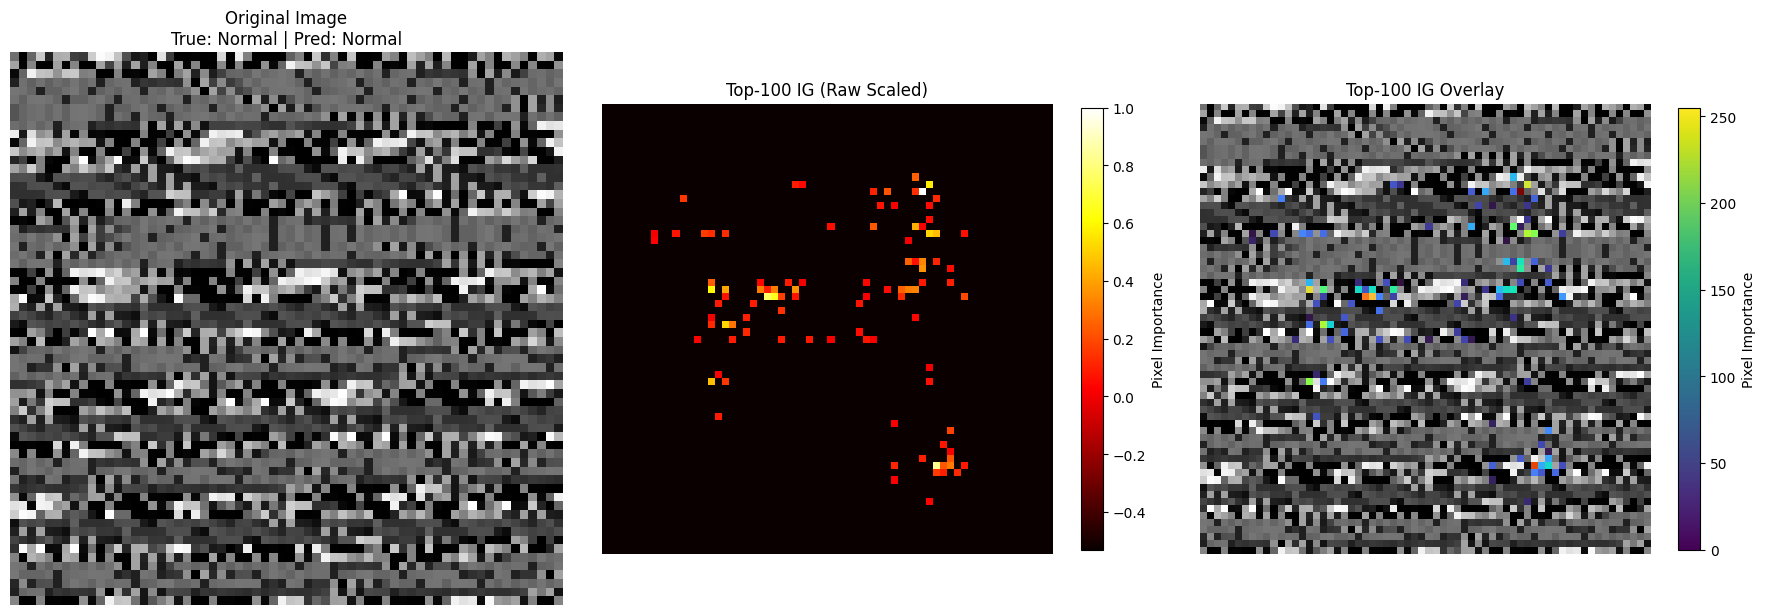

Encoded Message: oN
Decoded Message: oN
Messages Match: Matched

[11/772] Processing image_00011.png


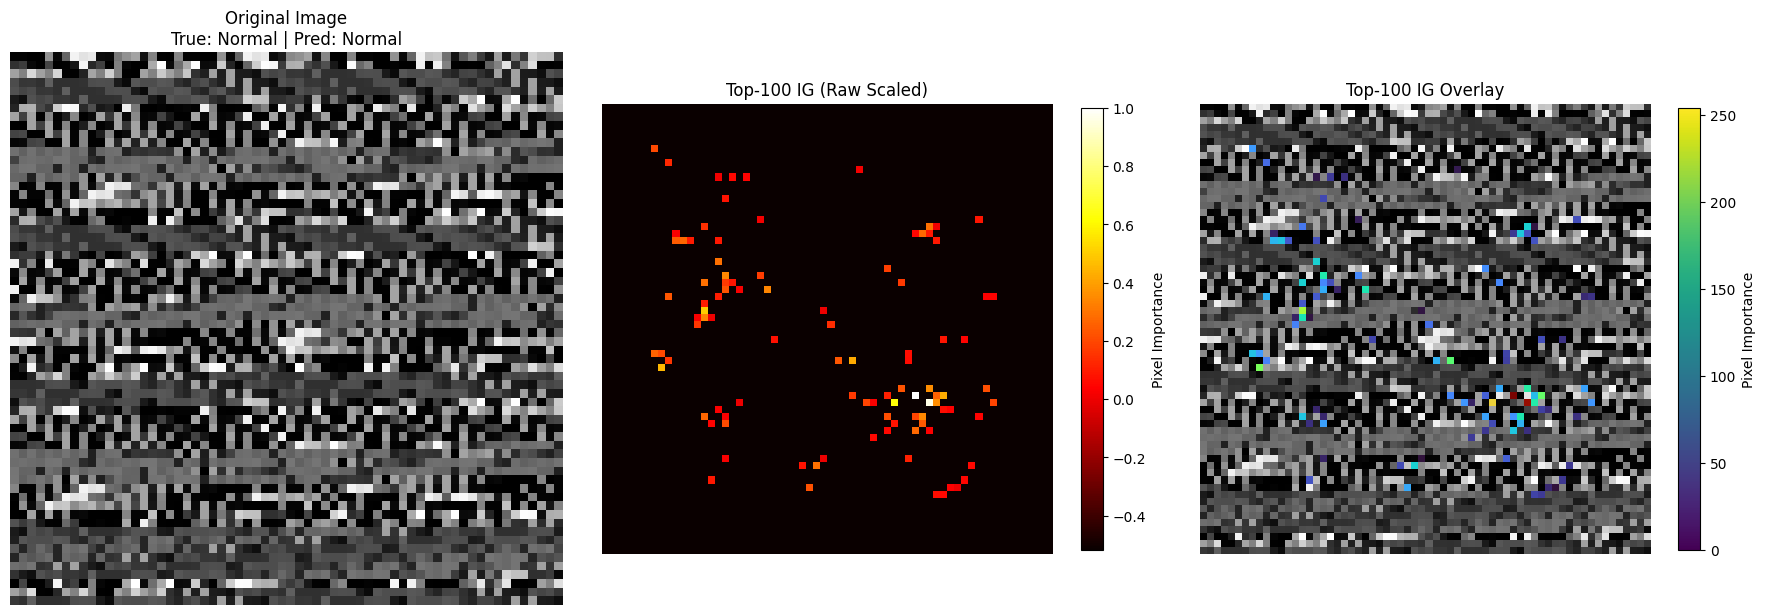

Encoded Message: OD
Decoded Message: OD
Messages Match: Matched

[12/772] Processing image_00012.png


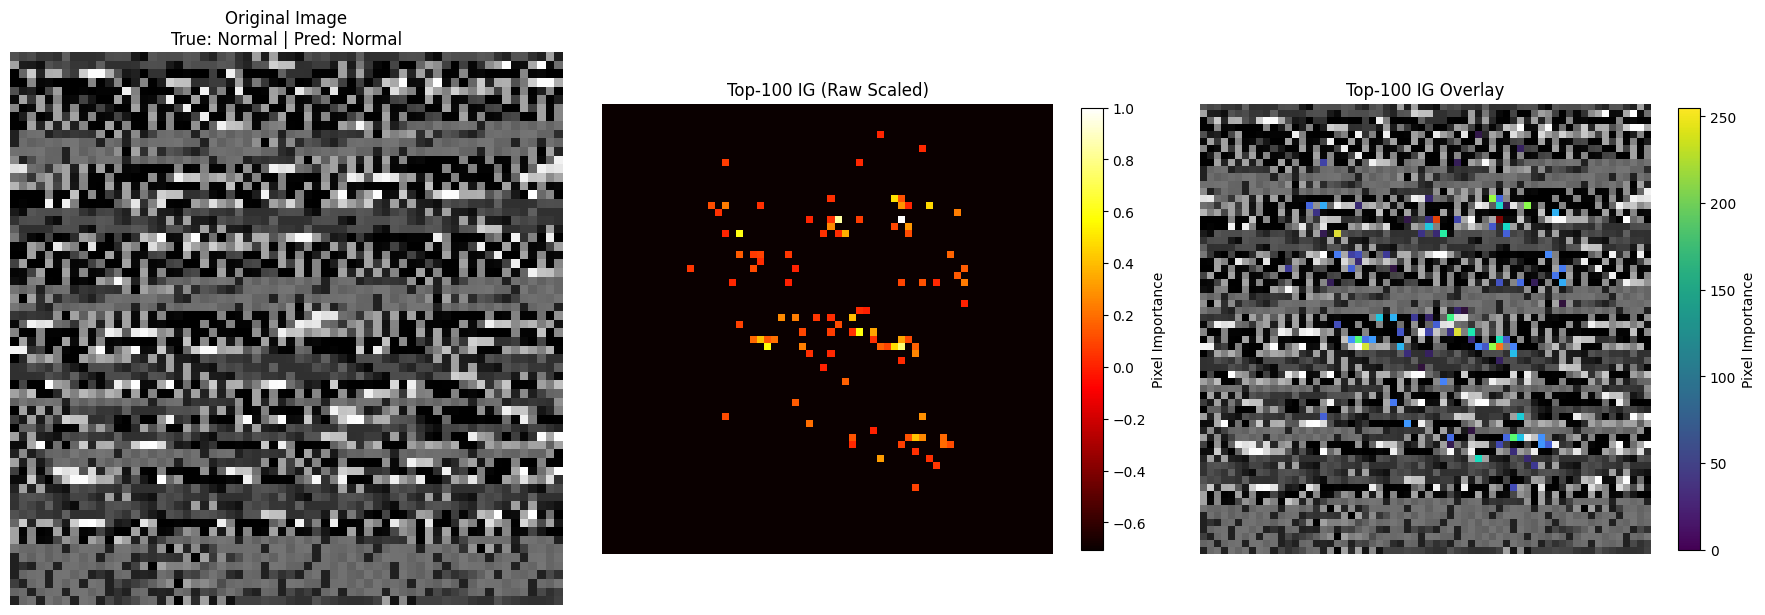

Encoded Message: 4T
Decoded Message: 4T
Messages Match: Matched

[13/772] Processing image_00013.png


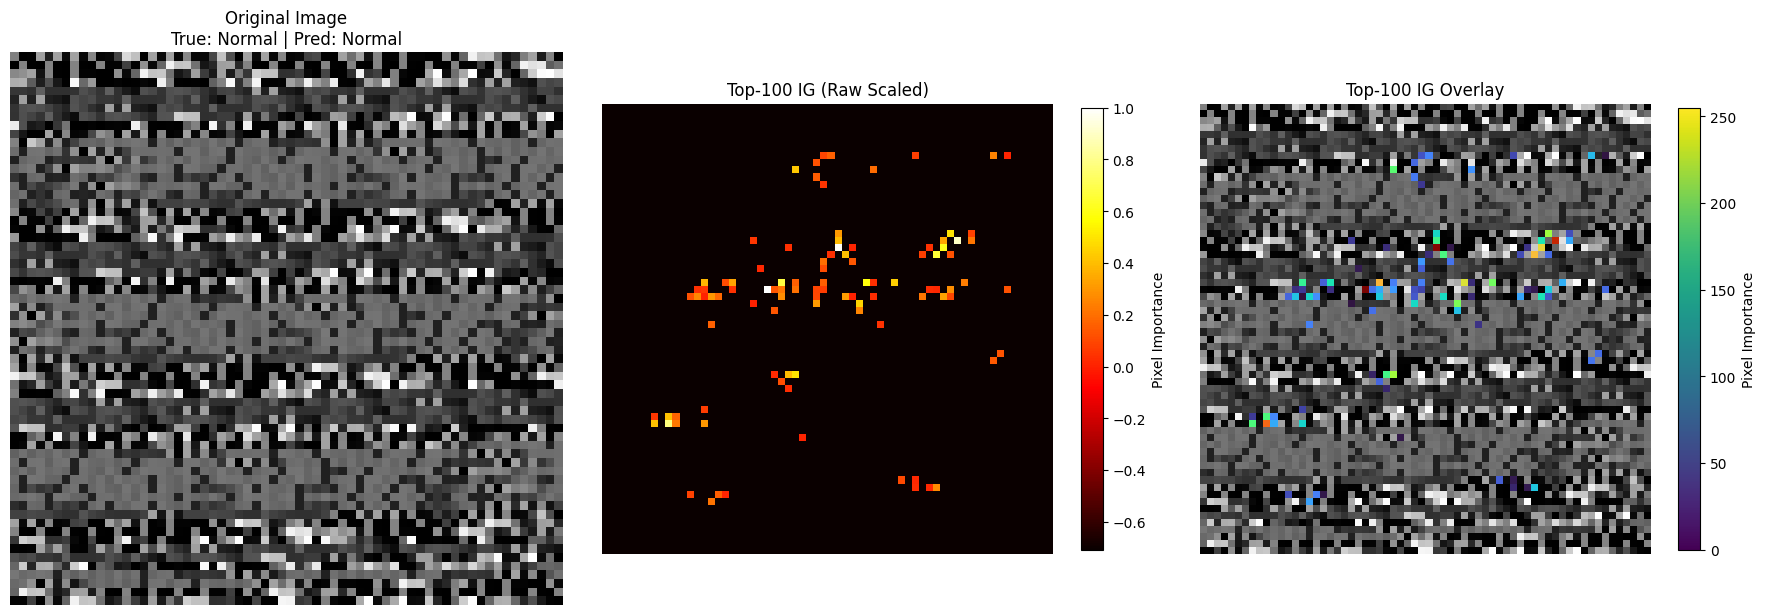

Encoded Message: GY
Decoded Message: GY
Messages Match: Matched

[14/772] Processing image_00014.png


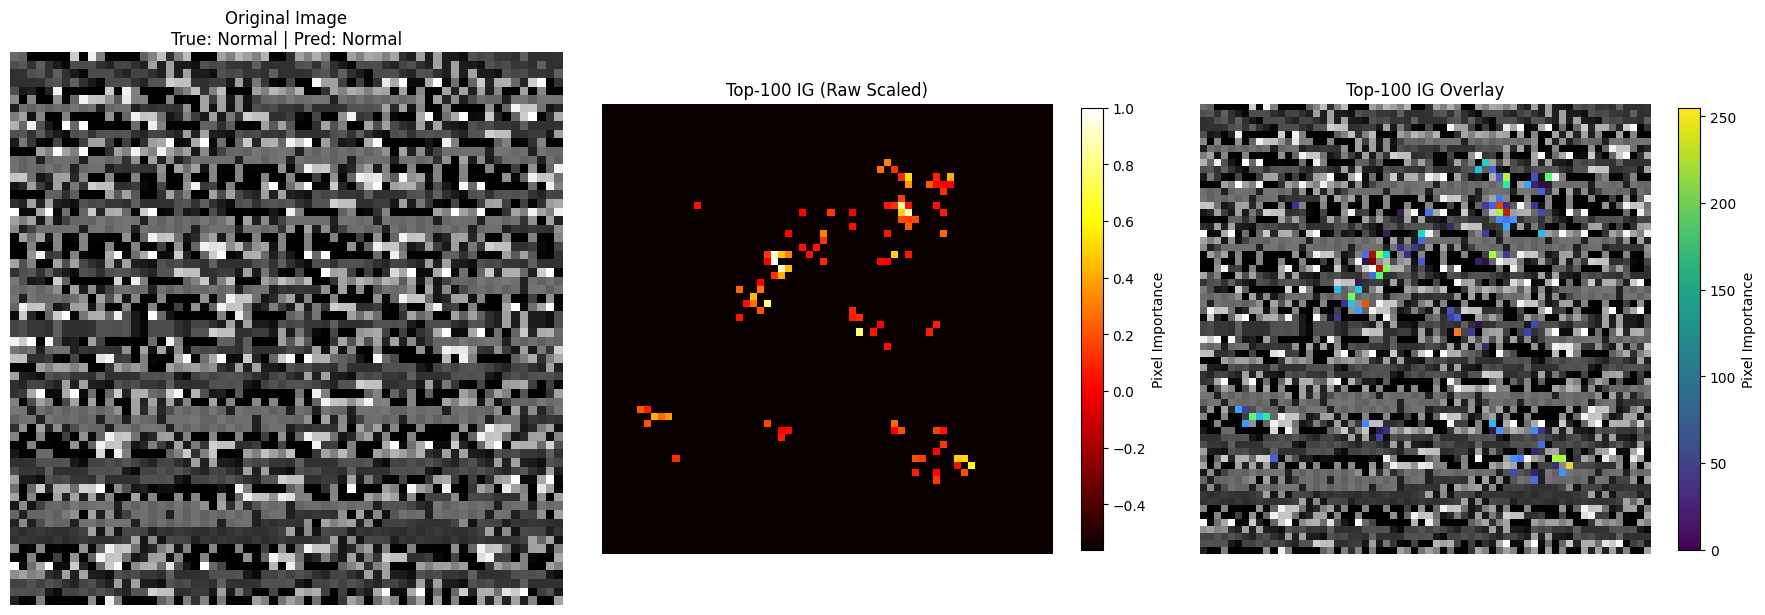

Encoded Message: 1H
Decoded Message: 1H
Messages Match: Matched

[15/772] Processing image_00015.png


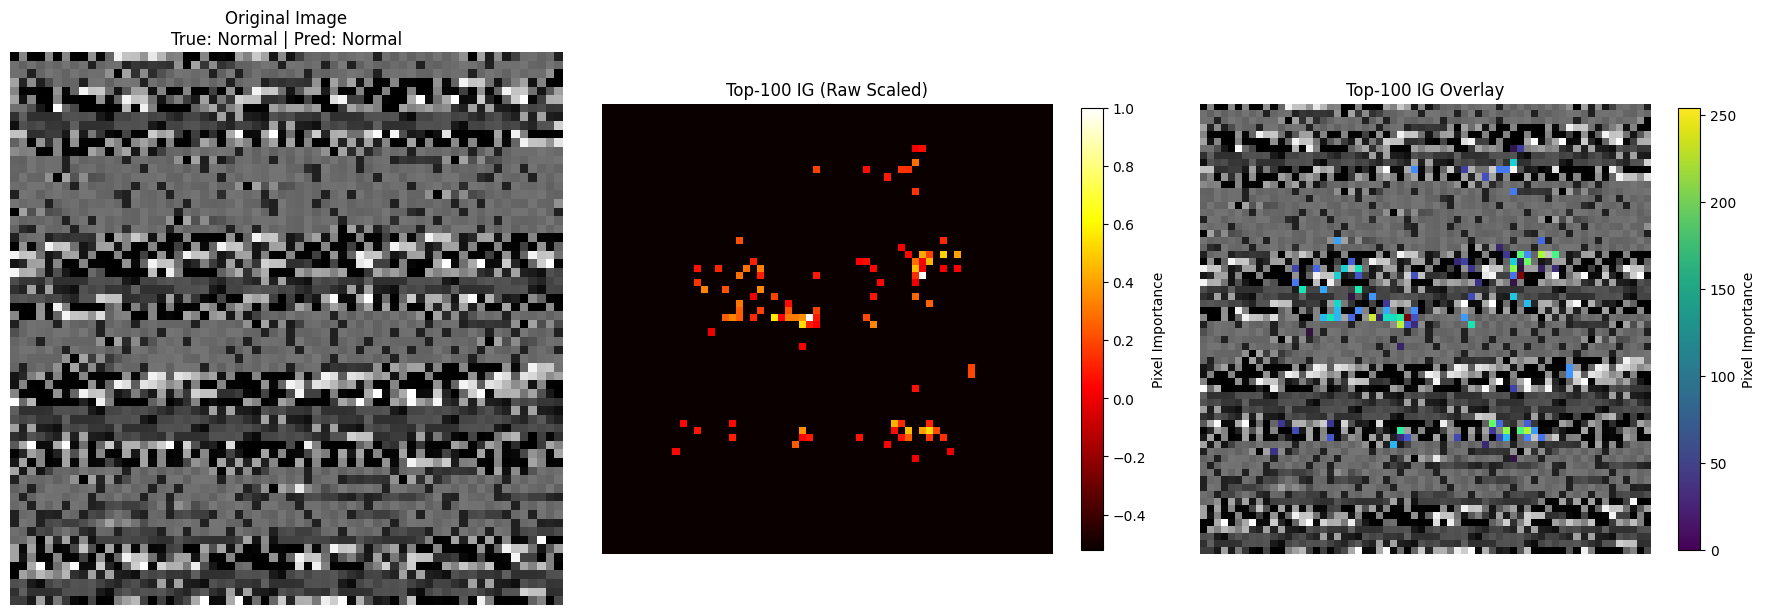

Encoded Message: dW
Decoded Message: dW
Messages Match: Matched

[16/772] Processing image_00016.png


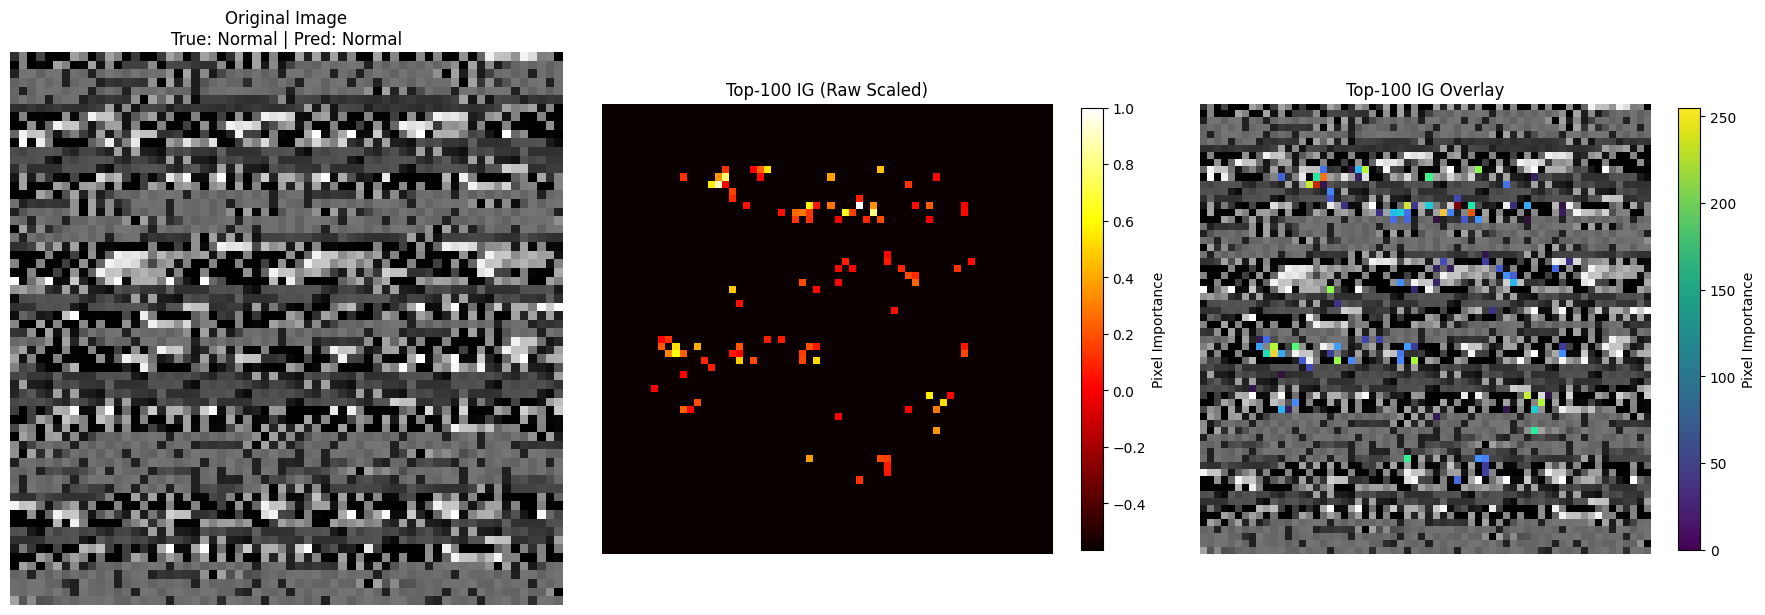

Encoded Message: lO
Decoded Message: lO
Messages Match: Matched

[17/772] Processing image_00017.png


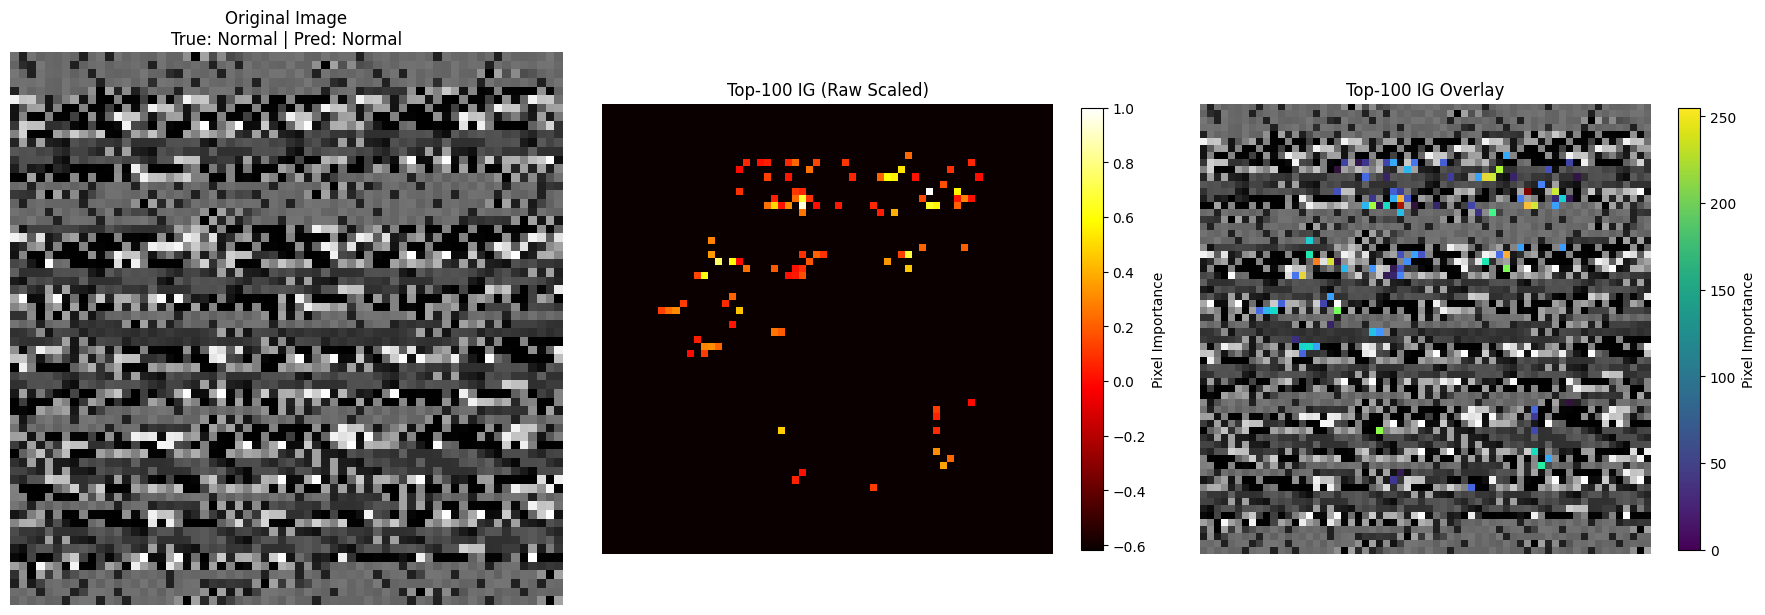

Encoded Message: wM
Decoded Message: wM
Messages Match: Matched

[18/772] Processing image_00018.png


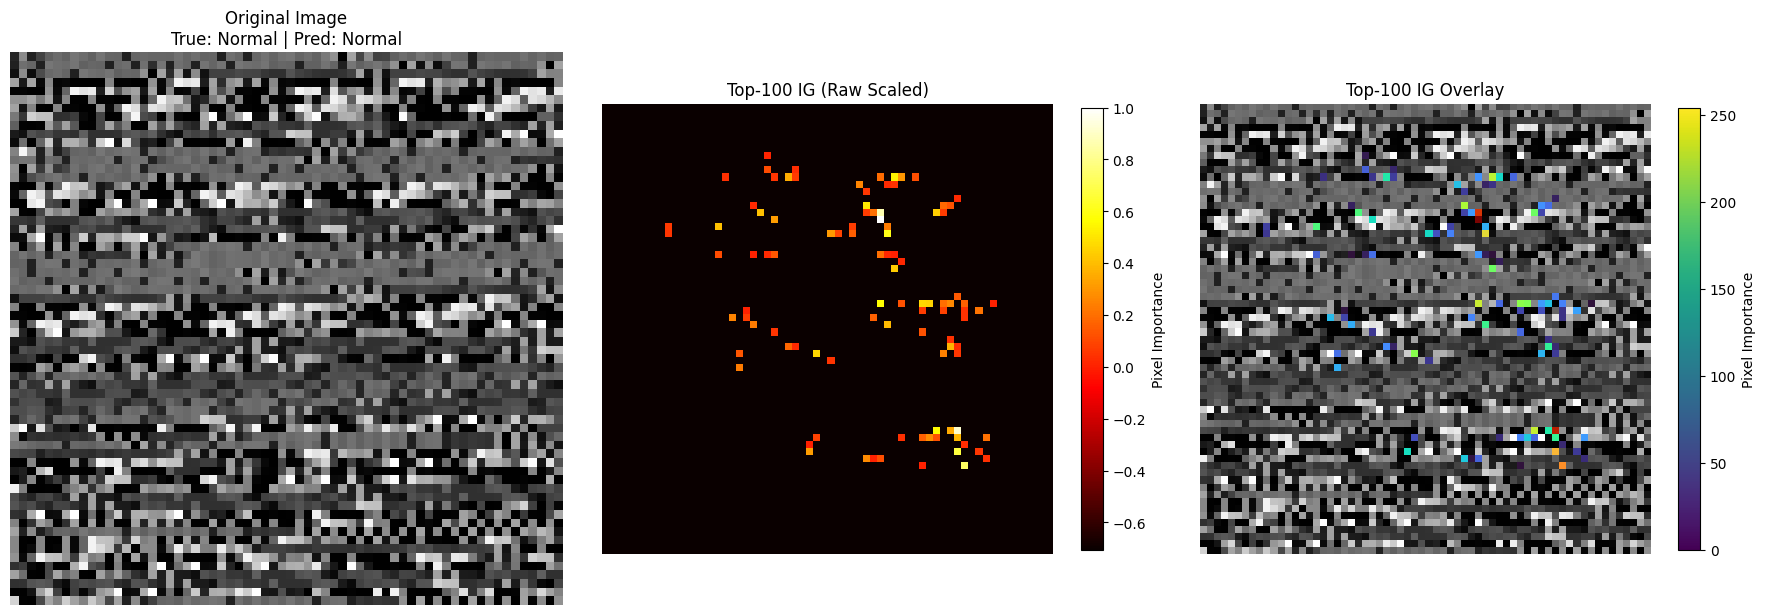

Encoded Message: 53
Decoded Message: 53
Messages Match: Matched

[19/772] Processing image_00019.png


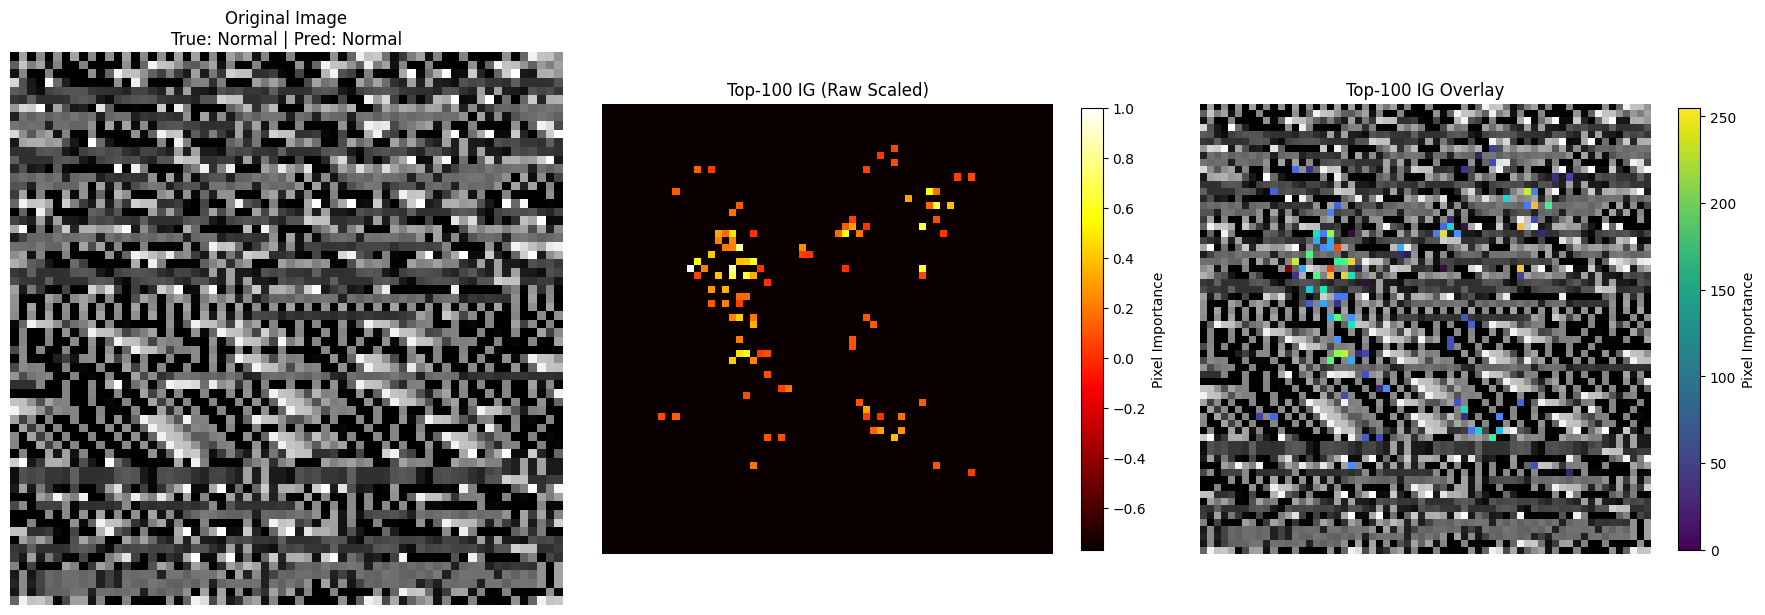

Encoded Message: 40
Decoded Message: 40
Messages Match: Matched

[20/772] Processing image_00020.png


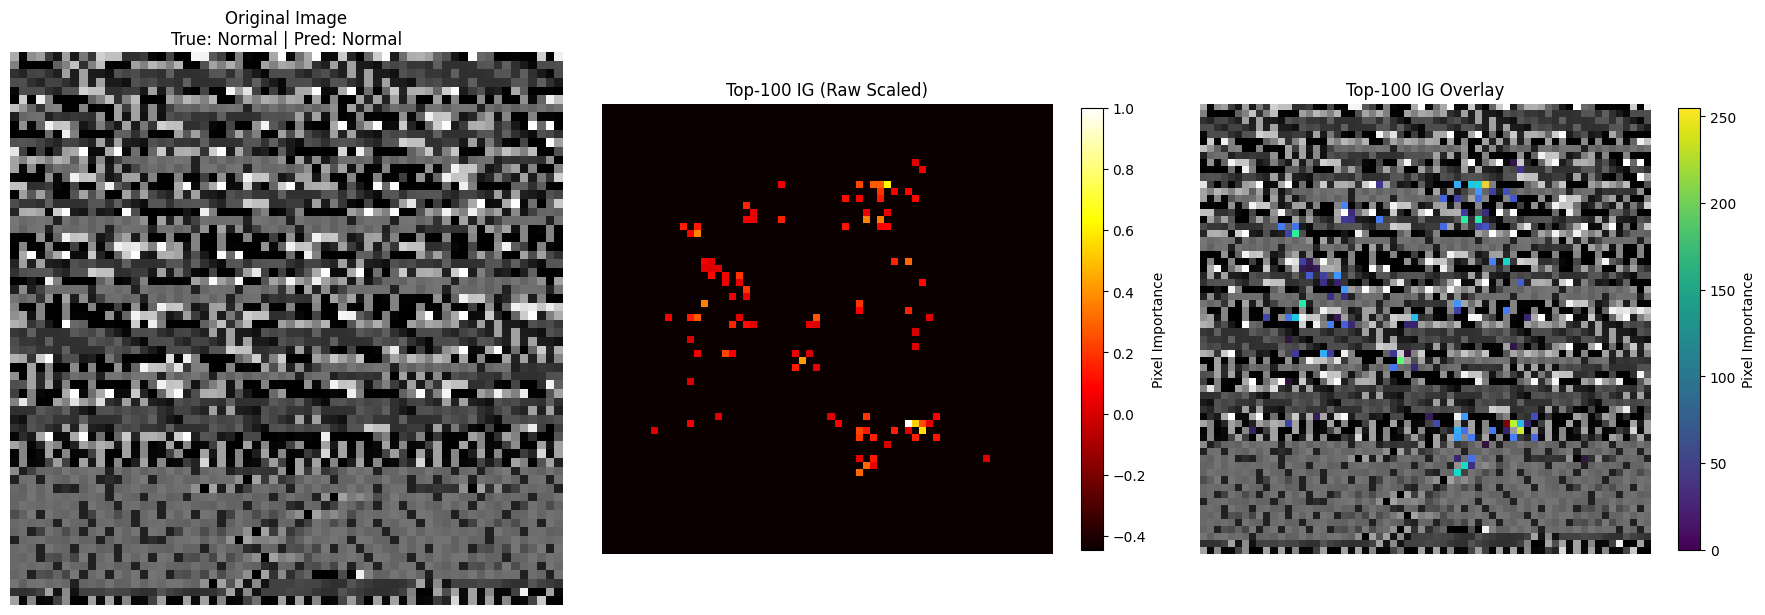

Encoded Message: jR
Decoded Message: jR
Messages Match: Matched

[21/772] Processing image_00021.png


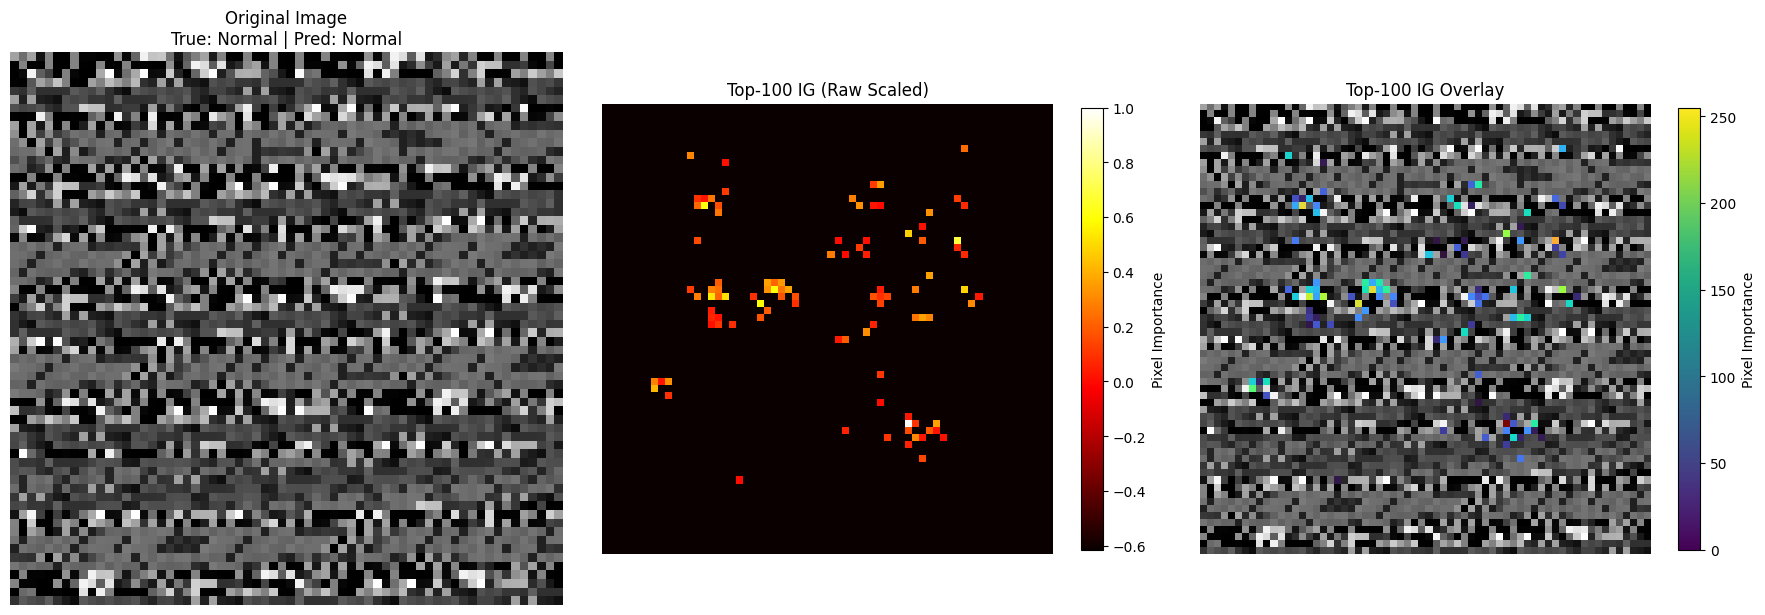

KeyboardInterrupt: 

In [72]:
# === Run === #
if __name__ == "__main__":
    input_folder = r"C:\Users\SIL-Laptop\Desktop\Final IAI Gustavo\steganography\Layered IG LSB\CNN MMS\Normal"
    model_path = r"C:\Users\SIL-Laptop\Desktop\Final IAI Gustavo\steganography\Layered IG LSB\CNN MMS\cnn_3_class_grayscale_model_64x64.h5"
    output_excel = r"C:\Users\SIL-Laptop\Desktop\Final IAI Gustavo\steganography\Layered IG LSB\CNN MMS\ig_layered_stego_results.xlsx"
    ig_vis_output_folder = r"C:\Users\SIL-Laptop\Desktop\Final IAI Gustavo\steganography\Layered IG LSB\CNN MMS\ig_visualizations"

    # Specify the path for saving stego images
    stego_output_folder = r"C:\Users\SIL-Laptop\Desktop\Final IAI Gustavo\steganography\Layered IG LSB\CNN MMS\stego_images"

    # Run the process
    process_folder(input_folder, model_path, output_excel, stego_output_folder, ig_vis_output_folder)
